In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 40.71 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(), # Add horizontal flip
    transforms.RandomRotation(10),    # Add random rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [8]:
# Set the batch size
BATCH_SIZE = 16 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb7e53de810>,
 ['pizza', 'steak', 'sushi'])

In [9]:
set_seeds()
img,label = next(iter(train_dataloader))
img[0].shape,label[0].item()

(torch.Size([3, 224, 224]), 2)

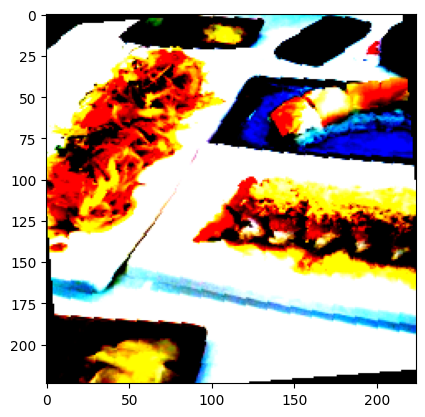

In [10]:
plt.imshow(img[0].permute(1,2,0))

In [11]:
import torch
import torch.nn as nn
from torchvision import models


# Load pretrained ResNet and remove final classification layer
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Outputs [batch, 512, 1, 1]

for param in resnet.parameters():
    param.requires_grad = False

class RNN(nn.Module):
    def __init__(self, n_inputs, hidden, n_outputs, rnn_layers):
        super(RNN, self).__init__()
        self.resnet = resnet
        self.M = hidden
        self.K = n_outputs
        self.LY = rnn_layers
        self.D = n_inputs  # should match 512 from ResNet

        self.LSTM = nn.LSTM(
            input_size=self.D,  # Must match ResNet output feature size
            hidden_size=self.M,
            num_layers=self.LY,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(self.M*2, self.K)

    def forward(self, x):
        batch_size = x.size(0)

        with torch.no_grad():
            features = self.resnet(x)  # [batch, 512, 1, 1]
            features = features.view(batch_size, 1, -1)  # [batch, seq_len=1, 512]

        h0 = torch.zeros(self.LY*2, batch_size, self.M).to(device)
        c0 = torch.zeros(self.LY*2, batch_size, self.M).to(device)

        out, _ = self.LSTM(features, (h0, c0))  # [batch, seq_len=1, hidden]
        out = self.fc(out[:, -1, :])  # Take last time step output
        return out


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


In [12]:
model = RNN(512,128,3,2)
model.to(device)

RNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)



In [14]:
from going_modular.going_modular import engine
set_seeds()
results = engine.train(model,
                       train_dataloader,
                       test_dataloader,
                       optimizer,
                       loss_fn=criterion,
                       epochs=6,
                       device=device)


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0465 | train_acc: 0.4875 | test_loss: 0.9491 | test_acc: 0.4364
Epoch: 2 | train_loss: 0.9288 | train_acc: 0.5875 | test_loss: 0.7514 | test_acc: 0.7170
Epoch: 3 | train_loss: 0.7878 | train_acc: 0.6292 | test_loss: 0.6524 | test_acc: 0.7648
Epoch: 4 | train_loss: 0.5291 | train_acc: 0.8125 | test_loss: 0.6202 | test_acc: 0.7841
Epoch: 5 | train_loss: 0.4088 | train_acc: 0.8708 | test_loss: 0.6772 | test_acc: 0.7341
Epoch: 6 | train_loss: 0.3561 | train_acc: 0.8375 | test_loss: 0.4446 | test_acc: 0.8398


In [15]:
results

{'train_loss': [1.0465044498443603,
  0.9288241227467855,
  0.7878093540668487,
  0.5291463275750478,
  0.4087523639202118,
  0.3560503656665484],
 'train_acc': [0.4875,
  0.5875,
  0.6291666666666667,
  0.8125,
  0.8708333333333333,
  0.8375],
 'test_loss': [0.9490542650222779,
  0.7514140486717225,
  0.6524183213710785,
  0.6202122747898102,
  0.6771595537662506,
  0.44461095333099365],
 'test_acc': [0.43636363636363634,
  0.7170454545454545,
  0.7647727272727273,
  0.7840909090909091,
  0.7340909090909091,
  0.8397727272727273]}

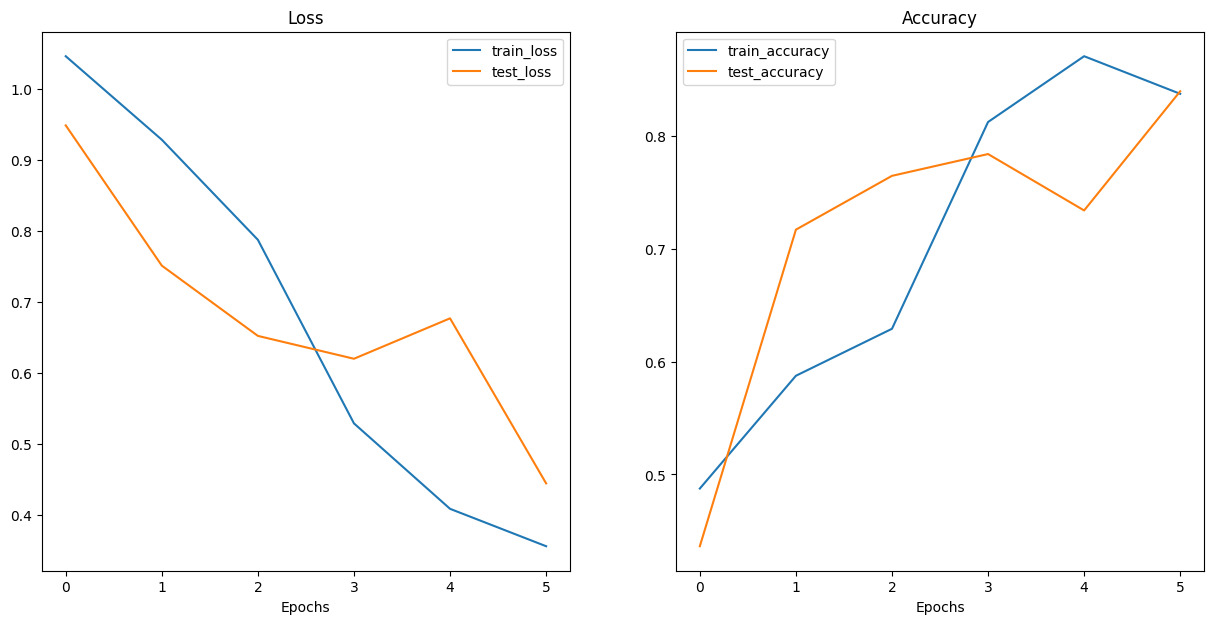

In [16]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [17]:

# Example to calculate accuracy during inference
correct = 0
total = 0

for X, labels in test_dataloader:
    with torch.inference_mode():
        X=X.to(device)
        labels=labels.to(device)
        pred = model(X)
        # Assuming the labels are the ground truth and pred are the predictions
        _, predicted = torch.max(pred, 1)  # Get the class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')


Accuracy on test set: 89.33%


In [18]:
img[0].shape
img[0]=img[0].unsqueeze(0)
img[0].shape

torch.Size([3, 224, 224])

In [19]:
model(img.to(device)).argmax(dim=1)

tensor([2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 1], device='cuda:0')

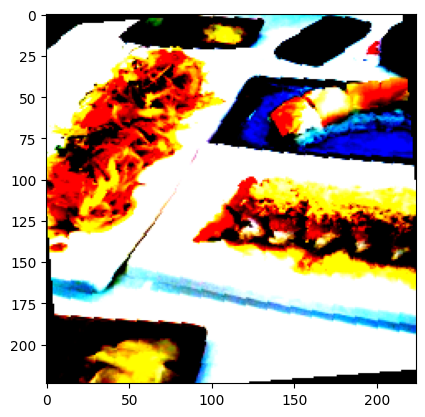

In [20]:
plt.imshow(img[0].permute(1,2,0))